# **The Transformer: An implementation in PyTorch**

The past years, the field of artificial intelligence has been shaped by the rise of transformer-based models, trained for tasks such as language understanding and generation. Although the original work of Vaswani et al. "Attention is all you need" focuses on natural language processing (NLP) tasks, since then many transformer-based models have emerged in different fields, including more modalities i.e. images, video, audio, etc. 

The most important component of Transformers is the Attention mechanism (last meeting's presentation), which allows the model to pay attention to different parts of the input sentence and assign weights depending on their importance for the predicting word. This mechanism enables Transformers to extract long-range dependencies in data, by considering different parts of the input regardless of their distance from each other.

In this work, we will see an implementation of the original and basic Transformer model in PyTorch, tested on a simple setup. The aim of this tutorial is to provide an understanding of how to build such a model.

## **Architecture**

Transformers are based on an Encoder-Decoder architecture:

<img src="trans.png" width="450" height="600" style="margin:auto"/>

There are five core processes that we need to understand to implement this model:

* **Embedding of the inputs**
* **Positional Encoding**
* **Masks**
* **Multi-Head Attention layer**
* **Feed-Forward layer**

For the rest, we assume that we are in the context of next word prediction in a machine translation task. In this context, each word is split into tokens so the model performs next token prediction.

## **Importing the necessary libraries and modules**

In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable

import math

/nvme/h/gkourmouli/.conda/envs/multimae/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## **Embeddings**

Embeddings are low-dimensional, dense vector representations of high-dimensional data. They are used to capture the underlying structure and relationships within the data in a more compact and meaningful way. They are common in NLP, but they can be applied to various types of data.

Embeddings are handled simply in pytorch:

In [2]:
word_embedding = nn.Embedding(vocab_size, d_model)

The above code assign every input word/token to an embedding vector, which in the training phase will be learnt by the model as trainable parameters.

## **Positional Encoding**

In order for the model to perform the next token prediction task, it needs to understand and find patterns within a sentence. For the model, this means understanding the meaning of each token and its position in the sentence.

The meaning of the tokens is learned by the embedding vector. What about their position in the sentence?

The positions are learned by the positional encodings. In the architecture:

<img src="position.png" style="margin:auto"/>

They are functions that create values for each position through the formulas:

<img src="positional.png" style="margin:auto"/>

where *pos* represents the order/position of a token in the sentence and *i* its dimension. 

The sinusoidal functions are chosen to allow the model to learn to attend to relative positions through a more unique and smooth encoding for each position than the assignment of a simple natural number i.e. 0, 1, ...

The above equations then create a constant 2D matrix that stores all the information about the positions of the tokens. Eventually, this matrix will be added to the input/source matrix which has all the input sentences. After the addition, the input sequence will gain some information about the position of the tokens and each token embedding will be altered based on its corresponding position vector. 

In PyTorch this is translated as:

In [3]:
class PositionalEncoding(nn.Module):
    """ Computation of positional encodings
        based on sin and cos functions
    """
    def __init__(self, max_length, d_model, device):
        super(PositionalEncoding, self).__init__()
        self.max_length = max_length
        self.d_model = d_model
        self.device = device

        self.pos_encod = torch.zeros(max_length, d_model, device=device)

        # create indices pos = [0, 1,..., max_length] and 2i = [0, 2,..., d_model]
        pos = torch.arange(0, max_length, device=device).float().unsqueeze(dim=1)
        i2 = torch.arange(0, d_model, step=2, device=device).float()

        # compute sinusoids
        # sin: for even indices
        # cos: for odd indices
        self.pos_encod[:, 0::2] = torch.sin(pos / (10000**(i2/d_model)))
        self.pos_encod[:, 1::2] = torch.cos(pos / (10000**(i2/d_model)))
                                                
    def forward(self, x):
        N, seq_size = x.shape

        pos_embedding = self.pos_encod[:seq_size, :]
        pos_embedding = pos_embedding.expand(N, seq_size, self.d_model)
        pos_embedding = pos_embedding.to(self.device)
        # print('positional encoding shape', pos_embedding.shape, '\n')

        return pos_embedding

Variables in PositionalEncoding class:
* max_length: Maximum length of all sequences - sentences longer than this will be filtered out
* d_model: Inner dimension of the model's input - the dimension of the embedding vector
* device: The device on which the calculations will be performed - cpu or gpu
* pos_encod: Tensor that will store all the positional encodings
* pos: Tensor with all the positions in the sentence
* i2: Scaling term for position indices

And some basic variables that we will use throughout the notebook:

* N, seq_size: # of inputs, size of each input
* x: input

## **Masks**

In Transformers we usually use two types of masks:

* **Padding Mask**: It is used in the encoder and decoder and basically hides the paddings that were added to the source and target sequences, so that the model will not make any computations for them. 

* **No-peak Mask**: It is used in the decoder to prevent it from seeing the next tokens of the target sequence when predicting the next word. With this mask decoder is able to see only up to the word it has predicted in the previous round.

The mask for the source sequence - Padding Mask:

In [4]:
def make_src_mask(self, src):
    src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)
    # resulting mask shape: (N, 1, 1, src_length)
    src_mask = src_mask.to(self.device)
    return src_mask     

The mask for the target sequence - Padding & No-Peak Mask:

In [5]:
def make_trg_mask(self, trg):
    N, trg_length = trg.shape
    trg_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
    trg_mask = trg_mask.to(self.device)

    # create a lower triangular matrix so that decoder cannot see following words
    no_peak_mask = torch.tril(torch.ones((trg_length, trg_length)))\
               .expand(N, 1, trg_length, trg_length)
    no_peak_mask = Variable(torch.tensor(no_peak_mask == 1).to(self.device))
    no_peak_mask = no_peak_mask.to(self.device)

    trg_mask = trg_mask & no_peak_mask
    return trg_mask

Variables in mask functions:
* src, trg: Source and target sequences
* src_mask, trg_mask: Mask for the input/source and target sequence
* src_pad_idx, trg_pad_idx: Padding indices for source and target sequence
* src_length, trg_length: Length of source and target sequence

The input of the encoder is the source sentence and that of the decoder is the translated sentence. After the first Multi-Head Attention calculations, the decoder takes also all the outputs of the encoder and the translated sentence up to the word which it is predicting and makes its predictions. By using the no-peak mask, we prevent the decoder from calculating attention scores based on the following words.

## **Multi-Head Attention**

The Multi-Head attention mechanism computes the attention between each pair of words in a sequence. It consists of multiple attention heads and each of them attends to a different part of the input sequence. 

The attention layer has two components:

* **Self Attention** or **Scaled Dot-Product Attention**
* **Multi-Head Attention**

### **Self Attention**

To calculate the attention we use the following equation:

<img src="attention.png" style="margin:auto"/>

The steps to calculate it:

<img src="selfattention.png" style="margin:auto"/>

where V, Q, K are the values, queries, and keys respectively. 

Initially, we must multiply Q with the traspose of K and the result is then scaled by the square root of *d_k = d_model/# of heads*. Before calculating the Softmax we can optionally apply a mask so that the padded indices are filtered out and in the case of decoder the no-peak mask. We then perform a dot-product between the result and V. 

In [6]:
class ScaledDotProductAttention(nn.Module):
    def __init__(self):
        super(ScaledDotProductAttention, self).__init__()
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, values, keys, queries, mask=None):
        # compute matrix multiplication and scale it
        # keys shape: (N, key_len, n_heads, d_head)
        # queries shape: (N, query_len, n_heads, d_head)
        # product shape: (N, n_heads, query_len, key_len) 
        # scale factor: sqrt(d_head)
        product = torch.einsum('nqhd,nkhd->nhqk', [queries, keys])

        # apply mask (optional)
        if mask is not None:
            product = product.masked_fill(mask==0, float('-1e20'))

        # compute attention and pass it from softmax
        scaled_product = product/math.sqrt(keys.shape[3])
        attention = self.softmax(scaled_product)

        # compute attention
        # attention shape: (N, n_heads, query_len, key_len)
        # values shape: (N, value_len, n_heads, d_head)
        # always value_len=key_len so we multiply across that dimension
        # out shape: (N, query_len, n_heads, d_head)
        out = torch.einsum('nhqk,nkhd->nqhd', [attention, values])

        return out

Variables in ScaledDotProductAttention class:
* n_heads: # of heads
* d_head: Dimension of each head and equal to *d_model/n_heads*

### **Multi-Head Attention**

In MHA each input is split into multiple heads so that the model can attend *simultaneously* to different parts of the embedding. We split the embedding vector into N heads and each of them receives an input of dimension *N * seq_length * (d_model/# of heads)*.

<img src="multihead.png" style="margin:auto"/>

In [7]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_heads):
        super(MultiHeadAttention, self).__init__()
        self.d_model = d_model          # embedding size
        self.n_heads = n_heads          # h in paper
        self.d_head = d_model//n_heads  # integer division, d_k,d_v in paper
        self.attention = ScaledDotProductAttention()

        # assertion to ensure that d_model is divided by n_heads
        assert (self.d_head*n_heads == d_model), 'The number of heads should\
                divide the dimension of the model'

        # Linear layers to pass V,K,Q + final linear layer (after concat)
        self.values_lin = nn.Linear(self.d_head, self.d_head, bias=False)
        self.keys_lin = nn.Linear(self.d_head, self.d_head, bias=False)
        self.queries_lin = nn.Linear(self.d_head, self.d_head, bias=False)
        self.fc_out = nn.Linear(self.d_head*n_heads, self.d_model)      # concatenation of heads outputs

    def forward(self, values, keys, queries, mask):
        N = queries.shape[0]   # # of training samples that we send in the model at the same time
        value_len = values.shape[1]
        key_len = keys.shape[1]
        query_len = queries.shape[1]

        # split the inputs V,K,Q into head parts and create matrices
        values = values.reshape(N, value_len, self.n_heads, self.d_head)
        keys = keys.reshape(N, key_len, self.n_heads, self.d_head)
        queries = queries.reshape(N, query_len, self.n_heads, self.d_head)

        # pass them from corresponding linear layers
        values = self.values_lin(values)       
        keys = self.keys_lin(keys)       
        queries = self.queries_lin(queries)

        # compute scale dot-product attention
        attention = self.attention(values, keys, queries, mask)

        # concatenate the results from scale dot-product attention 
        # attention shape: (N, query_len, n_heads, d_head)
        # so we flatten the last two dimensions n_heads*d_head = d_model
        # concatenated shape: (N, query_len, d_model)
        concatenated = attention.reshape(N, query_len, self.n_heads*self.d_head)

        # pass the concat tensor from linear layer
        # output shape: (N, query_len, d_model)
        out = self.fc_out(concatenated)

        return out

Variables in MultiHeadAttention class:
* d_model: Embedding size
* n_heads: # of heads
* d_head: Dimension of each head and equal to *d_model/n_heads*

## **Feed-Forward Network**

The position-wise feed-forward neural network consists of two linear layers with a ReLU activation function in between. It is applied to each position separately, and it processes and transforms the attention outputs. These type of networks makes the models deeper by using linear functions and better at analysing patterns. 

In [8]:
class PositionWiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super(PositionWiseFeedForward, self).__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(d_ff, d_model)
        self.feed_forward = nn.Sequential(self.linear1, 
                                        self.relu, 
                                        self.linear2)

    def forward(self, x):
        out = self.feed_forward(x)
        return out

Variables in PositionWiseFeedForward class:
* d_model: Embedding size
* d_ff: Inner dimension of feed forward operations

## **Transformer Block**

In both encoder and decoder there is a Transformer block:

<img src="transfblock.png" style="margin:auto"/>


It consists of:
* **MHA**
* **Feed-Forward Network**
* **Normalization**

Normalization prevents the range of values from changing too much by keeping all the values within a certain range. This way the model trains faster and has better ability to generalise.

In [9]:
class TransformerBlock(nn.Module):
    """ One transformer block:

        Multi-head attention 
        Skip connection and normalization layer
        Feed forward layer
        Skip connection and normalization layer
    """
    def __init__(self, d_model, n_heads, dropout, d_ff):
        super(TransformerBlock, self).__init__()
        self.attention = MultiHeadAttention(d_model, n_heads)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)  

    def forward(self, values, keys, queries, mask):
        attention = self.attention(values, keys, queries, mask)
        x = self.dropout(self.norm1(attention + queries))  # skip connection 'attention + queries'
        forward = self.feed_forward(x)
        out = self.dropout(self.norm2(forward + x))   # skip connection 'forward + x'

        return out

Variables in TransformerBlock class:
* d_model: Embedding size
* n_heads: # of heads
* dropout: Dropout operation
* d_ff: Inner dimension of feed forward operations

## **Encoder**

We will now build the Encoder layer. The Transformer model repeats this layer *Nx* times to produce the values and keys from the source sentence which will then be fed to the decoder.

<img src="encoder.png" style="margin:auto"/>

It consists of:
* **Embeddings of input**
* **Positional Encodings**
* **Transformer Block**


In [10]:
class Encoder(nn.Module):
    """ One encoder block ≡ one transformer block
        One encoder block with the computations of its input layer:

        Tranform input into an embedding
        Compute positional encoding of the input sequence
        Create the input for the transformer (addition of the two above)
        Transformer block
    """
    def __init__(self, src_vocab_size, d_model, n_layers, n_heads, 
                dropout, d_ff, max_length, device):
        super(Encoder, self).__init__()
        self.d_model = d_model
        self.n_layers = n_layers
        self.device = device
        self.word_embedding = nn.Embedding(src_vocab_size, d_model)
        self.position_embedding = PositionalEncoding(max_length, d_model, device)

        # version 2 of positional encoding
        # self.position_embedding = nn.Embedding(max_length, d_model)

        self.layers = nn.ModuleList(
            [
                TransformerBlock(d_model, n_heads, dropout, d_ff)
                for _ in range(n_layers)
            ]
        )
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, mask):
        # version 2 of positional encoding for each of the input sequences        
        # N, seq_size = x.shape
        # positions = torch.arange(0, seq_size)
        # positions = positions.expand(N, seq_size).to(self.device)
        # embedding = self.word_embedding(x) + self.position_embedding(positions)
        # print('encoder positional encoding shape', self.position_embedding(positions).shape)

        # input embedding with the positional encodings
        # print('encoder')
        embedding = self.word_embedding(x) + self.position_embedding(x)
        out = self.dropout(embedding)

        # layers
        for layer in self.layers:
            out = layer(out, out, out, mask)

        return out

Variables in Encoder class:
* src_vocab_size: The size of the source vocabulary
* d_model: Embedding size
* n_layers: # of layers
* n_heads: # of heads
* dropout: Dropout operation
* d_ff: Inner dimension of feed forward operations
* max_length: Maximum sequence length
* device: CPU or GPU

## **Decoder Block**

To build the decoder we first create the decoder block. The Transformer model repeats this layer *Nx* times to predict the next word.

<img src="decoderblock.png" style="margin:auto"/>

It consists of:
* **Masked MHA**: So that the decoder cannot see *future* predictions
* **Transformer Block**


In [11]:
class DecoderBlock(nn.Module):
    """ One decoder block ≡ multi-head attention + 
                            skip connection and normalization layer + 
                            one transformer block
                            
        One decoder block with the computations of its input layer:

        Tranform input into an embedding
        Compute positional encoding of the input sequence
        Create the input for the first layer (addition of the two above)
        Multi-head attention 
        Skip connection and normalization layer
        Transformer block (keys, values from encoder + queries from the input)
    """
    def __init__(self, d_model, n_heads, dropout, d_ff):
        super(DecoderBlock, self).__init__()
        self.attention = MultiHeadAttention(d_model, n_heads)
        self.norm = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        self.transformer_block = TransformerBlock(d_model, n_heads, dropout, d_ff)

    # values and keys come from the encoder
    # x is the input of the decoder
    def forward(self, values, keys, x, src_mask, trg_mask):
        attention = self.attention(x, x, x, trg_mask)  # masked MHA in decoder so we need to pass target mask
        queries = self.dropout(self.norm(attention + x))
        out = self.transformer_block(values, keys, queries, src_mask)
        return out

Variables in DecoderBlock class:
* d_model: Embedding size
* n_heads: # of heads
* dropout: Dropout operation
* d_ff: Inner dimension of feed forward operations
* x: Input of decoder - target sequence
* src_mask, trg_mask: Source and target mask

## **Decoder**

We will now build the Decoder layer using the Decoder Block that we created previously:

<img src="decoder.png" style="margin:auto"/>

It consists of:
* **Embeddings of decoder input**: This is the target sequence
* **Positional Encodings**
* **Decoder Block**
* **Linear Projection**: To project decoder's output to desired dimensions
* **Softmax**: To produce probabilities from predictions (logits)

The above combination enables the decoder to generate meaningful outputs based on the encoder's source representations, taking into account both the target sequence and the source sequence. 

In [12]:
class Decoder(nn.Module):
    def __init__(self, trg_vocab_size, d_model, n_layers, n_heads, 
                dropout, d_ff, max_length, device):
        super(Decoder, self).__init__()
        self.device = device
        self.word_embedding = nn.Embedding(trg_vocab_size, d_model)
        self.position_embedding = PositionalEncoding(max_length, d_model, device)

        # version 2 of positional encoding
        # self.position_embedding = nn.Embedding(max_length, d_model)
        
        self.layers = nn.ModuleList(
            [
                DecoderBlock(d_model, n_heads, dropout, d_ff)
                for _ in range(n_layers)
            ]
        )
        self.fc_out = nn.Linear(d_model, trg_vocab_size)
        self.dropout = nn.Dropout(dropout)

        # CHANGE if in training phase we want softmax on the output 
        self.softmax = nn.Softmax(dim=-1)
    
    def forward(self, encoder_out, x, src_mask, trg_mask):
        # version 2 of positional encoding for each of the input sequences        
        # N, seq_size = x.shape
        # positions = torch.arange(0, seq_size)
        # positions = positions.expand(N, seq_size).to(self.device)
        # embedding = self.word_embedding(x) + self.position_embedding(positions)
        # print('decoder positional encoding shape', self.position_embedding(positions).shape)

        # input embedding with the positional encodings
        # print('decoder')
        embedding = self.word_embedding(x) + self.position_embedding(x)
        x = self.dropout(embedding)

        # layers
        for layer in self.layers:
            x = layer(encoder_out, encoder_out, x, src_mask, trg_mask)

        # last linear layer and softmax
        out = self.fc_out(x)

        # CHANGE if in training phase we want softmax on the output
        out = self.softmax(out)

        return out

Variables in Decoder class:
* trg_vocab_size: The size of the target vocabulary
* n_layers: # of layers
* d_model: Embedding size
* n_heads: # of heads
* dropout: Dropout operation
* d_ff: Inner dimension of feed forward operations
* max_length: Maximum sequence length
* device: CPU or GPU

## **Putting it all together**

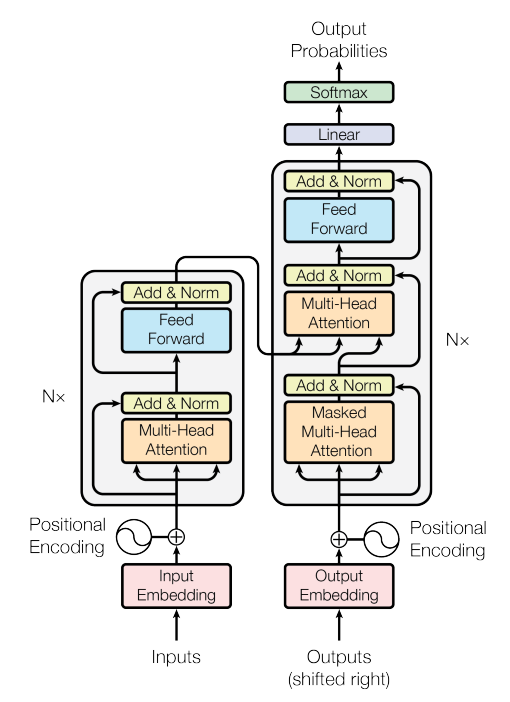We will now combine the Encoder and Decoder layers to create the Transformer model:

<img src="trans.png" style="margin:auto"/>

During initialization, we can define all the hyperparameters of the model (e.g. n_layers, n_heads, etc.) or we can keep the default values stated in the Transformer class which in this case are the values from the original paper. So the Transformer model is able to process input sequences, extract patterns, and produce output sequences.

In [13]:
class Transformer(nn.Module):
    """ Putting everything together to form Transformer

        Variables:
        src_pad_idx, trg_pad_idx: necessary to compute source and target masks

        Functions
        make_src_mask:  create masks for source
                        if it is a source pad index then set to 0
                        if it is not set to 1 
        make_trg_mask: create masks for target
    """
    def __init__(self, src_vocab_size, trg_vocab_size, src_pad_idx, trg_pad_idx,
                 d_model=512, n_layers=6, n_heads=8, device="cuda", d_ff=2048, 
                 dropout=0, max_length=100):
        super(Transformer, self).__init__()
        self.encoder = Encoder(src_vocab_size, d_model, n_layers, n_heads, 
                                dropout, d_ff, max_length, device)
        self.decoder = Decoder(trg_vocab_size, d_model, n_layers, n_heads, 
                                dropout, d_ff, max_length, device)
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device

    def make_src_mask(self, src):
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)
        # resulting mask shape: (N, 1, 1, src_length)
        src_mask = src_mask.to(self.device)
        return src_mask     

    def make_trg_mask(self, trg):
        N, trg_length = trg.shape
        trg_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
        trg_mask = trg_mask.to(self.device)
        
        # create a lower triangular matrix so that decoder cannot see following words
        no_peak_mask = torch.tril(torch.ones((trg_length, trg_length)))\
                   .expand(N, 1, trg_length, trg_length)
        no_peak_mask = Variable(torch.tensor(no_peak_mask == 1).to(self.device))
        no_peak_mask = no_peak_mask.to(self.device)
    
        trg_mask = trg_mask & no_peak_mask
        return trg_mask

    def forward(self, src, trg):
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)

        encoder_src = self.encoder(src, src_mask)
        out = self.decoder(encoder_src, trg, src_mask, trg_mask)

        return out

## <h1><center>$\cdots$</center></h1>

## **Simple example**

In this very simple example, we will create a toy dataset just to check that the code is working and the model can produce outputs. In practice, such a model needs a larger dataset, some preprocessing steps, tokenization, vocabulary mappings, and training for a downstream task.  

In [14]:
if __name__=="__main__":
    n_layers = 6
    d_model = 512
    d_ff = 2048
    n_heads = 8
    dropout = 0.1
    max_length = 20
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

    src_pad_idx = 0
    trg_pad_idx = 0
    src_vocab_size = 10
    trg_vocab_size = 10
    
    src = torch.tensor([[2,3,2,6,8,4,9,5,1,0], [3,5,7,3,7,9,2,7,8,1]]) 
    # src = torch.randint(1, src_vocab_size, (3, max_length)) # size (batch_size, seq_length)
    src = src.to(device)
    trg = torch.tensor([[3,5,7,8,9,2,1,0,0], [2,4,5,8,3,1,0,0,0]])
    # trg = torch.randint(1, trg_vocab_size, (3, max_length))  # size (batch_size, seq_length)
    trg = trg.to(device)

    model = Transformer(
            src_vocab_size, trg_vocab_size, src_pad_idx, trg_pad_idx,
            d_model, n_layers, n_heads, device, d_ff, dropout, max_length
            )
    model = model.to(device)

    # send in model src as is and trg without the last token that we want to predict
    out = model(src, trg[:, :-1])
    _, preds = torch.max(out, dim=1)

    print('source shape:', src.shape, 
          '\ntarget shape:', trg.shape,
          '\ntarget shifted right shape:', trg[:, :-1].shape,
          '\noutput shape:', out.shape, '\n')
    print('predictions size\n', preds.shape)
    print('predictions\n', preds, '\n')
    
    # print(trg)
    # print(out)
#     print(_)
    print('model', model)

source shape: torch.Size([2, 10]) 
target shape: torch.Size([2, 9]) 
target shifted right shape: torch.Size([2, 8]) 
output shape: torch.Size([2, 8, 10]) 

predictions size
 torch.Size([2, 10])
predictions
 tensor([[1, 2, 7, 6, 3, 4, 5, 5, 1, 3],
        [2, 4, 2, 5, 1, 2, 0, 0, 3, 7]], device='cuda:0') 

model Transformer(
  (encoder): Encoder(
    (word_embedding): Embedding(10, 512)
    (position_embedding): PositionalEncoding()
    (layers): ModuleList(
      (0): TransformerBlock(
        (attention): MultiHeadAttention(
          (attention): ScaledDotProductAttention(
            (softmax): Softmax(dim=-1)
          )
          (values_lin): Linear(in_features=64, out_features=64, bias=False)
          (keys_lin): Linear(in_features=64, out_features=64, bias=False)
          (queries_lin): Linear(in_features=64, out_features=64, bias=False)
          (fc_out): Linear(in_features=512, out_features=512, bias=True)
        )
        (feed_forward): PositionWiseFeedForward(
        

/tmp/ipykernel_170406/698584254.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  no_peak_mask = Variable(torch.tensor(no_peak_mask == 1).to(self.device))


## <h1><center>$\cdots$</center></h1>

## **References**

### **Attention is all you need**
Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Łukasz Kaiser, and Illia Polosukhin. 2017. Attention is all you need. In Proceedings of the 31st International Conference on Neural Information Processing Systems (NIPS'17).